In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# librerías para el texto
import nltk
from nltk.corpus import stopwords
import spacy


import torch
from transformers import BertTokenizer, BertModel

c:\Users\daalvarado\CSvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
netflix = pd.read_csv(r'../data/netflix/film_reviews_result.csv', sep='|', encoding='utf-8')

In [3]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10058 entries, 0 to 10057
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   film_name      10058 non-null  object
 1   gender         10058 non-null  object
 2   film_avg_rate  10058 non-null  object
 3   review_rate    10058 non-null  int64 
 4   review_title   10058 non-null  object
 5   review_text    10058 non-null  object
dtypes: int64(1), object(5)
memory usage: 471.6+ KB


In [4]:
netflix_gp = netflix.groupby(by='film_name').agg(
        conteo=('film_name', 'size'),
        avg_review=('review_rate', 'mean')
    ).reset_index().sort_values(by=['conteo', 'avg_review'], ascending=False)

In [5]:
netflix_gp_maxrate = netflix_gp[netflix_gp['avg_review'] == netflix_gp['avg_review'].max()]

In [6]:
netflix_gp_t = netflix_gp[netflix_gp['conteo'] >= 10]
netflix_gp_maxrate_mtt = netflix_gp_t[netflix_gp_t['avg_review'] == netflix_gp_t['avg_review'].max()]
netflix_gp_maxrate_mtt

,film_name,conteo,avg_review
113,Cortar por la línea de puntos (Miniserie de TV),21,8.809524


<Axes: >

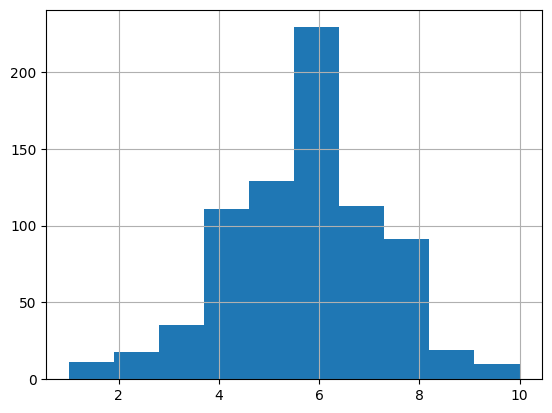

In [7]:
netflix_gp['avg_review'].round(decimals=0).hist()

In [8]:
barplot = netflix_gp.groupby('conteo').mean('avg_review').reset_index()
barplot

,conteo,avg_review
0,1,5.794702
1,2,5.908602
2,3,5.650602
3,4,5.812500
4,5,6.204348
...,...,...
75,196,6.362245
76,246,6.987805
77,271,7.302583
78,320,6.303125


In [9]:
netflix_cutted = netflix
#conditions = [(netflix_cutted['review_rate'] >= 0) & (netflix_cutted['review_rate'] < 4),
#              (netflix_cutted['review_rate'] >= 4) & (netflix_cutted['review_rate'] <= 6),
#              (netflix_cutted['review_rate'] > 6) & (netflix_cutted['review_rate'] <= 10)]
#labels = ['Mala', 'Pasable/Normal', 'Buena']
#netflix_cutted['Divition'] = np.select(conditions, labels, default=np.nan)

In [10]:
stop_words = set(stopwords.words('spanish'))

In [11]:
# APLICADO A CADENAS DE TEXTO
def remove_stop_words(text : str) -> str:
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def eliminar_etiquetas_html(texto : str) -> str:
    # Usamos una expresión regular para buscar y eliminar etiquetas HTML
    texto_limpio = re.sub(r'<.*?>', '', texto)
    return texto_limpio

def limpiar_texto(texto : str) -> str:
    # Eliminar caracteres especiales o no alfanuméricos
    return re.sub(r'[^A-Za-z0-9 ]+', '', texto)

def lemmatizador(text : str) -> str:
    # cargamos el modelo en espaniol
    nlp = spacy.load("es_core_news_sm")

    # procesamos el texto
    processed = nlp(text)

    # Extraemos los lemas
    lemmas = [token.lemma_ for token in processed]

    return ' '.join(lemmas)


def caracteres_especiales(texto : str) -> str:
    return re.sub(r'[^\w\s]', ' ', texto)

def espacios_extra(texto : str) -> str:
    return re.sub(r'\s+', ' ', texto).strip()



# APLICADO A COLUMNAS

# Función para eliminar etiquetas HTML de una columna
def eliminar_etiquetas_html2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    df[col_out] = df[col_in].apply(lambda x: re.sub(r'<.*?>', '', x) if isinstance(x, str) else x)
    return df

# Función para limpiar caracteres especiales de una columna
def limpiar_texto2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    df[col_out] = df[col_in].apply(lambda x: re.sub(r'[^\w\s.,]', '', x) if isinstance(x, str) else x)
    return df

# ------------->
# correción de funcion para limpiar caracteres especiales
def caracteres_especiales2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    df[col_out] = df[col_in].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if isinstance(x, str) else x)
    return df

def espacios_extra2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    df[col_out] = df[col_in].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
    return df
# ------------->

# Función para eliminar palabras vacías de una columna
def remove_stop_words2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    df[col_out] = df[col_in].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]) if isinstance(x, str) else x)
    return df

def lemmatizador2(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    # cargamos el modelo en espaniol
    nlp = spacy.load('es_core_news_sm')

    # aplicamos a cada fila de la columna entrada
    df[col_out] = df[col_in].apply(
        lambda x: ' '.join([token.lemma_ for token in nlp(x)]) if isinstance(x, str) else x
    )
    return df

def rating(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    conditions = [
        (df[col_in] >= 0) & (df[col_in] < 4),
        (df[col_in] >= 4) & (df[col_in] <= 6),
        (df[col_in] > 6) & (df[col_in] <= 10)]
    labels = ['Mala', 'Pasable/Normal', 'Buena']
    df[col_out] = np.select(conditions, labels, default=np.nan)
    return df


def rating_token(df : pd.DataFrame, col_in : str | int, col_out : str | int) -> pd.DataFrame:
    conditions = [
        (df[col_in] >= 0) & (df[col_in] <= 5),
        (df[col_in] >= 6) & (df[col_in] <= 10)]
    labels = [0, 1]
    df[col_out] = np.select(conditions, labels, default=np.nan)
    return df


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def vectorizador(texto : str) -> torch.Tensor:
    # se tokeniza la oración para convertirse en una estructura BERT
    inputs = tokenizer(texto, return_tensors='pt')

    # se desactiva el calculo del gradiente
    with torch.no_grad():
        outputs = model(**inputs)
    
    # extraemos los embeddings
    embeddings = outputs.last_hidden_state
    return embeddings


def obtener_embeddings(texto : str) -> np.array:
    # Mover el modelo a GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Tokenización del texto y creacion de tensores
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generar embeddings con BERT sin cálculo de gradientes
    with torch.no_grad():
        outputs = model(**inputs)

    # tomar el embedding de la ultima capa
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()


def get_embedding(texto : str) -> np.array:
    # Tokenizacion y creación de tensores
    inputs = tokenizer(texto, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad(): # desactivar el calculo de gradientes
        outputs = model(**inputs)
        # extraer el embedding de [CLS] (índice 0)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.squeeze().numpy()


In [12]:
netflix_pipped = (netflix_cutted
                  .pipe(eliminar_etiquetas_html2, 'review_text', 'review_text_mod')         # Quitamos etiquetas HTML 
                  .pipe(caracteres_especiales2, 'review_text_mod', 'review_text_mod')       # limpiamos carácteres especiales
                  .pipe(espacios_extra2, 'review_text_mod', 'review_text_mod')              # quitamos espacios extra
                  .pipe(remove_stop_words2, 'review_text_mod', 'review_text_mod')           # Quitamos 'stopwords' (de, le, el, a, y, etc.)
                  .pipe(lemmatizador2, 'review_text_mod', 'review_text_mod')                # Transformamos las palabras a
                  .pipe(rating, 'review_rate', 'review_rate_class')                         # Colocamos el rate_class dependiendo del rating
                  .pipe(rating_token, 'review_rate', 'review_rate_token'))                        

In [14]:
#netflix_pipped['review_text_mod_embeddings'] = netflix_pipped['review_text_mod'].apply(get_embedding)

### Pruebas Extra

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\daalvarado\CSvenv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\daalvarado\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
sentence = 'El banco está cerca del parque y también es una institución financiera.'

In [ ]:
inputs = tokenizer(sentence, return_tensors='pt')

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
embeddings = outputs.last_hidden_state

In [ ]:
embeddings.shape

torch.Size([1, 26, 768])

In [ ]:
inputs

{'input_ids': tensor([[  101,  3449, 28678,  9765,  2050,  8292, 18992,  3972, 11968,  4226,
          1061, 17214, 11283,  2078,  9686, 14477, 16021,  3775,  8525, 10446,
         10346,  2319, 19562,  2050,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}